<a href="https://colab.research.google.com/github/AayushKucheria/ML-Bootcamp/blob/main/01_backprop_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network - from scratch to Pytorch

In this notebook, I build a network that approximates the sine function with a 3rd degree polynomial.

To understand pytorch mechanics better, I'll be gradually moving up the abstraction ladder. Initially, building the whole network and learning simply using Numpy, and then adding abstractions to the code step-by-step and making it easier.

1. Bare Numpy (computing gradient by hand)
2. Bare Pytorch: using Tensors (same as above)
3. Using Autograd
4. Using torch.nn
5. Optimizer abstraction (stopped iterating on parameters to update them)

Sources/Inspiration
1. https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
2. https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d1/pytorch_tuto.ipynb

# Bare Numpy: Implementing the network using numpy

Numpy isn't aware of computation graphs, deep learning, or gradients. So I'll be manually implementing the forward and backward passes through the network using numpy operations.

In [ ]:
import numpy as np
import math

# Creating random input and output data
# Why math.pi? Coz we're playing with sine
x = np.linspace(-math.pi, math.pi, 2000) # Generates random numbers over the interval
y = np.sin(x)

# Randomly initializing weights for the 3rd degree polynomial
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

# plot_y = []
plot_y_pred = []
lr = 1e-6
epochs = 2000

for t in range(epochs):
    # Forward pass: Compute predicted y
    y_pred = a + b*x + c*(x**2) + d*(x**3) # Degree 3 polynomial
    plot_y_pred.append(y_pred)
    # Compute Loss (MSE)
    diff = y_pred - y
    loss = (diff**2).sum()
    if t % 100 == 0:
        print(t, loss)
    
    # Compute gradients of the loss wrt a, b, c, d
    dl_dy = 2 *diff # Calculated by hand using the MSE formula

    # The sum decides the "direction" the gradient is pointing towards.
    # Could also use the mean but it'll be much slower
    grad_a = (dl_dy * 1).sum()
    grad_b = (dl_dy * x).sum()
    grad_c = (dl_dy * x**2).sum()
    grad_d = (dl_dy * x**3).sum()

    # Update weights using gradient descent
    a -= lr *  grad_a 
    b -= lr * grad_b
    c -= lr * grad_c
    d -= lr * grad_d

print(f"Result: y = {a} + {b}x + {c}x^2 + {d}x^3")


0 287518.48777536413
100 1602.7939525428735
200 1135.005688096289
300 804.5817875006161
400 571.158192701761
500 406.2409955440313
600 289.7125282604155
700 207.36696532074183
800 149.17167980273163
900 108.04038821634677
1000 78.96727779391443
1100 58.415799790710466
1200 43.88715935195668
1300 33.61562528980736
1400 26.353357618674472
1500 21.218432684596817
1600 17.587491136593645
1700 15.019897844583966
1800 13.204158005092747
1900 11.920054251762354
Result: y = 0.04950424450729623 + 0.8529734591509849x + -0.008540305931692874x^2 + -0.09279451148424846x^3


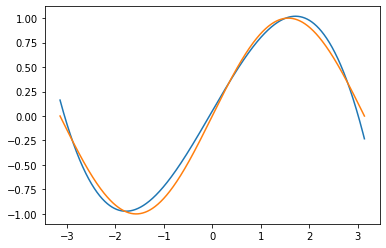

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y_pred)
plt.plot(x, y)

# Bare Pytorch: Tensors

Numpy cannot utilize GPUs, which is a HUGE drawback. To solve this, I'm gonna bring in "Tensors" from Pytorch.

It's basically a numpy array which works on a GPU, and keeps track of a computational graph and gradients.

Note that all we're doing here is replacing numpy arrays with pytorch tensors. To use the backward(), gradient, etc functionality - we still need to define autograd. Which isn't done here. So the code is pretty much still the same.

In [ ]:
import torch
import math

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

# Create input+output tensors
x = torch.linspace(-math.pi, math.pi, 2000, device=device)
y = torch.sin(x)

# Initialize random weight tensors.
# Since this is a 3rd order polynomial, we need 4 weights.
# And since we WANT to compute gradients on these tensors later on,
# we'll initialize them so.

a = torch.randn((), device=device, requires_grad=True) # Setting size as () sets it to 1 - a scalar tensor
b = torch.randn((), device=device, requires_grad=True)
c = torch.randn((), device=device, requires_grad=True)
d = torch.randn((), device=device, requires_grad=True)

lr = 1e-6
n_epochs = 2000
for t in range(n_epochs):
    
    # Forward pass
    y_pred = a + b*x + c*x**2 + d*x**3

    # Compute and print loss
    loss = ((y_pred - y)**2).sum()
    if t % 1000 == 0:
        print(t, loss)

    # Backprop to compute gradients of weights wrt loss
    grad_y = 2 * (y_pred - y)
    grad_a = (grad_y * 1).sum()
    grad_b = (grad_y * x).sum()
    grad_c = (grad_y * x**2).sum()
    grad_d = (grad_y * x**3).sum()

    # Update weights using gradient descent
    with torch.no_grad(): # Why: https://stackoverflow.com/questions/62198351/why-doesnt-pytorch-allow-inplace-operations-on-leaf-variables
        a -= lr * grad_a
        b -= lr * grad_b
        c -= lr * grad_c
        d -= lr * grad_d

print(f"Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3")

0 tensor(397060.0938, grad_fn=<SumBackward0>)
1000 tensor(44.3529, grad_fn=<SumBackward0>)
Result: y = -0.032403603196144104 + 0.847296953201294 x + 0.005590161774307489 x^2 + -0.09198707342147827 x^3


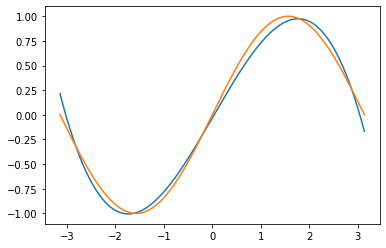

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y_pred.detach().numpy())
plt.plot(x, y)

# Autograd in Pytorch

Implementing the backward pass was kinda easy, but it gets super hard as the layers increase. Check [this](https://brilliant.org/wiki/backpropagation/) page out for details lol. But thankfully Autograd has automatic differentiation which, well, automates the computation of backward passes in NNs.

In Autograd, the forward pass defines a computational graph, with the nodes as tensors, and the edges as functions that input and output tensors. Backpropagating through this graph allows easy gradient computation.

In [ ]:
import torch
import math

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

# Initialize i/p and o/p tensors
x = torch.linspace(-math.pi, math.pi, 2000, device=device)
y = torch.sin(x)

# Initialize random weights.
# For a 3rd order polynomial, we need 4 weights: y = a + b*x + c*x^2 + d*x^3
a = torch.randn((), device=device, requires_grad=True)
b = torch.randn((), device=device, requires_grad=True)
c = torch.randn((), device=device, requires_grad=True)
d = torch.randn((), device=device, requires_grad=True)

lr = 1e-6
n_epochs = 2000
for t in range(epochs):
    # Forward Pass
    y_pred = a + b*x + c*x**2 + d*x**3

    # Compute and print loss
    loss = ((y_pred - y)**2).mean()
    if t % 100 == 0:
        print(t, loss.item())

    # Use autograd to compute the backward pass
    loss.backward()

    # Manually update weights using gradient descent
    with torch.no_grad(): # Why: https://stackoverflow.com/questions/62198351/why-doesnt-pytorch-allow-inplace-operations-on-leaf-variables
        a -= lr * a.grad
        b -= lr * b.grad
        c -= lr * c.grad
        d -= lr * d.grad
    
        # Manually zero gradients after updating weights
        # Either method works
        a.grad = torch.tensor(0.0, requires_grad=True)
        b.grad = torch.tensor(0.0, requires_grad=True)
        c.grad = None
        d.grad = None # Why does this work?

print(f"Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3")

0 416.12237548828125
100 393.51739501953125
200 372.1477355957031
300 351.94580078125
400 332.8480224609375
500 314.7942199707031
600 297.7264709472656
700 281.59124755859375
800 266.33770751953125
900 251.91775512695312
1000 238.28553771972656
1100 225.39816284179688
1200 213.2149658203125
1300 201.69749450683594
1400 190.8091583251953
1500 180.5157470703125
1600 170.7846221923828
1700 161.58506774902344
1800 152.88804626464844
1900 144.6660614013672
Result: y = -0.5667429566383362 + -0.9713417291641235 x + -0.128072127699852 x^2 + -0.8205883502960205 x^3


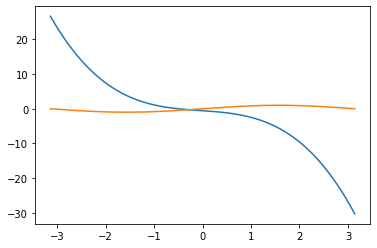

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y_pred.detach().numpy())
plt.plot(x, y)

# nn Module

Now, let's structure everything together into "Layers"

In [ ]:
import torch
import math

# Input/output tensors
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Since the polynomial function is linear, we can consider the network
# as a linear layer neural network.
# Preparing the tensor (x, x^2, x^3)
# Ie, Calculating powers of each x-element
p = torch.tensor([1, 2, 3])
# Squeeze elements one level inside, then calculate 3 of each ones' powers
xx = x.unsqueeze(-1).pow(p) # Damn fuck this is some good pytorch wizardry

torch.Size([3])


In [ ]:
"""
In the above code,

x.unsqueeze(-1) has shape ___1x2000 instead of 2000x1. That is, it transposes the vector.
NO! unsqueeze(1) will transpose it bruh. unsqueeze(-1) indents it a level inside. So it'll have
shape original x 1 instead of original

p has shape 3

xx will have shape original x 3
"""

In [ ]:
# Use the nn package to define our model as a sequence of layers
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

loss_fn = torch.nn.MSELoss(reduction='sum')
lr = 1e-6
n_epochs = 2000
for t in range(n_epochs):

    # Forward pass
    y_pred = model(xx)

    # Compute and print loss
    loss = loss_fn(y_pred, y)
    if t % 100 == 0:
        print(t, loss.item())
    
    # Zero the gradients before running the backward pass.
    # We do this just to make sure there aren't any backlogged updates that
    # get carried along in this iteration
    model.zero_grad()

    # Backward pass
    # Computes gradient of loss wrt all the learnable parameters of the model
    # The learnable parameters are all params with requires_grad = True
    loss.backward()

    # Update the weights using gradient descent
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
            # Manually zero gradients after updating weights
            param.grad = None

# Since we have only one layer, we can simply pick out it's weights and visualize them
linear_layer = model[0]
print(f"Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3")



0 52285.32421875
100 428.50262451171875
200 286.5834045410156
300 192.66653442382812
400 130.51251220703125
500 89.37663269042969
600 62.14966583251953
700 44.127464294433594
800 32.197364807128906
900 24.299428939819336
1000 19.070526123046875
1100 15.60830020904541
1200 13.315641403198242
1300 11.797358512878418
1400 10.791748046875
1500 10.125648498535156
1600 9.684379577636719
1700 9.39200210571289
1800 9.198262214660645
1900 9.069866180419922
Result: y = -0.002908254275098443 + 0.844417154788971 x + 0.0005017217481508851 x^2 + -0.09157744795084 x^3


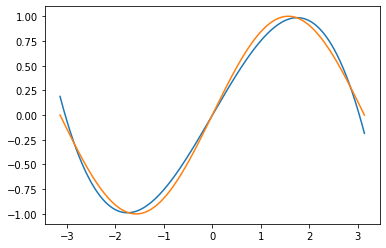

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y_pred.detach().numpy())
plt.plot(x, y)

# Optim
Finally, we automate everything that can be automated with the optim module which also updates the weights automatically!

In [ ]:
# Use the nn package to define our model as a sequence of layers
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.RMSprop(model.parameters(), lr=0.01)
lr = 1e-6
n_epochs = 2000
for t in range(n_epochs):

    # Forward pass
    y_pred = model(xx)

    # Compute and print loss
    loss = loss_fn(y_pred, y)
    if t % 100 == 0:
        print(t, loss.item())
    
    # Zero the gradients before running the backward pass.
    # We do this just to make sure there aren't any backlogged updates that
    # get carried along in this iteration
    optim.zero_grad()

    # Backward pass
    # Computes gradient of loss wrt all the learnable parameters of the model
    # The learnable parameters are all params with requires_grad = True
    loss.backward()

    # Update the weights using RMSProp
    optim.step()

# Since we have only one layer, we can simply pick out it's weights and visualize them
linear_layer = model[0]
print(f"Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3")


0 78186.1640625
100 339.21661376953125
200 127.15892791748047
300 31.66986083984375
400 10.355947494506836
500 8.834793090820312
600 12.158185958862305
700 14.753618240356445
800 9.502144813537598
900 9.81873893737793
1000 12.420866012573242
1100 20.64423942565918
1200 23.617156982421875
1300 18.386016845703125
1400 17.786296844482422
1500 19.4328670501709
1600 19.701974868774414
1700 19.047311782836914
1800 18.99478530883789
1900 19.23280143737793
Result: y = 0.005026446655392647 + 0.8617546558380127 x + 0.005026446655392647 x^2 + -0.08831659704446793 x^3


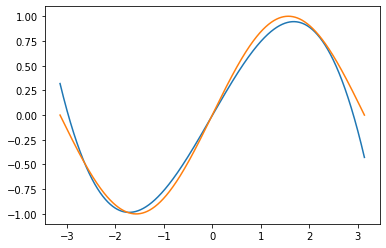

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y_pred.detach().numpy())
plt.plot(x, y)

In [1]:
"""
TODO: 
1. Learn how to define new autograd functions
2. Learn the mechanics of building custom nn modules
"""

'\nTODO: \n1. Learn how to define new autograd functions\n2. Learn the mechanics of building custom nn modules\n'